In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install imblearn

In [ ]:
pip install catboost

In [ ]:
pip install seaborn

In [ ]:
pip install optuna

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold,StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, accuracy_score, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFE
import optuna

d:\MyApplication\anaconda3\envs\mle_tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_feature = pd.read_csv('./training_set_features.csv', index_col=False)
df_label = pd.read_csv('./training_set_labels.csv', index_col=False)

In [3]:
df_feature.replace('',np.nan,inplace=True)

In [4]:
cat_cols = ['h1n1_concern', 'h1n1_knowledge','opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc','doctor_recc_h1n1','doctor_recc_seasonal','chronic_med_condition','health_worker','hhs_geo_region','census_msa','age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status']

In [5]:
for item in cat_cols:
    df_feature[item] = df_feature[item] .astype("category").cat.codes+1

In [16]:
df_feature['h1n1_vaccine'] = df_label['h1n1_vaccine']
df_feature['seasonal_vaccine'] = df_label['seasonal_vaccine']
df_vac = df_label['h1n1_vaccine'] | df_label['seasonal_vaccine']

In [6]:
df_feature = df_feature.drop(columns='respondent_id',axis=1)

In [ ]:
num_cols = df_feature.select_dtype('number').columns

In [ ]:
df_feature.describe()

In [ ]:
df_feature.isnull().sum(axis=0)

In [ ]:
df_label.describe()

In [ ]:
sns.countplot(x=df_label['h1n1_vaccine'], data=df_label)

In [ ]:
sns.countplot(x=df_label['seasonal_vaccine'], data=df_label)

In [ ]:
plt.hist(df_feature["age_group"], bins = 5)

plt.xlabel("Hourse Power")
plt.ylabel("Count")
plt.title("Total Horsepower Bins")

In [77]:
columns = ['hhs_geo_region','census_msa','age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status']
encoder = preprocessing.LabelEncoder()
for column in columns:
    df_feature[column] = encoder.fit_transform(df_feature[column])

In [78]:
enc = preprocessing.OneHotEncoder()
enc.fit_transform(df_feature[columns])
df_feature

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
0,2,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,...,3,0,2,1,0,1,8,2,0.0,0.0
1,4,3,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,...,3,1,2,1,1,0,1,0,0.0,0.0
2,2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,3,1,0,1,0,0,9,0,2.0,0.0
3,2,2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,...,3,0,2,1,1,1,5,1,0.0,0.0
4,3,2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1,...,3,0,0,0,0,0,9,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,3,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,...,3,0,0,1,0,1,9,2,0.0,0.0
26703,2,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,...,3,1,0,1,1,0,6,1,1.0,0.0
26704,3,3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1,...,3,0,3,1,0,3,6,0,0.0,0.0
26705,2,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,1,0,0,0,1,0,5,2,1.0,0.0


In [ ]:
fig,axs = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_feature,x='hhs_geo_region',y='income_qua',hue='h1n1_vaccine',ax=axs)

In [7]:
# df_feature.drop(columns=['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','employment_industry','employment_occupation','health_insurance','hhs_geo_region','census_msa'],axis=1,inplace=True)
df_feature.drop(columns=['health_insurance','employment_industry','employment_occupation'],axis=1,inplace=True)

In [ ]:
plt.figure(figsize=(25,15))
sns.heatmap(df_feature.corr(),annot=True)
plt.show()

In [8]:
df_feature = df_feature.dropna(thresh=4)
df_feature[df_feature.isna().any(axis=1)]

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
42,1,1,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,...,4,2,1,1,1,1,9,3,1.0,0.0
64,2,1,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1,...,3,1,0,0,0,0,5,3,1.0,2.0
76,3,2,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,...,4,2,2,2,1,1,4,2,1.0,0.0
96,0,2,0.0,1.0,0.0,1.0,0.0,NaN,0.0,2,...,4,1,1,2,1,2,7,3,0.0,0.0
105,2,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,...,4,1,0,0,0,0,9,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26613,1,3,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1,...,1,2,3,2,2,2,4,2,0.0,0.0
26652,2,2,0.0,1.0,NaN,1.0,1.0,1.0,NaN,1,...,3,2,1,1,1,2,2,1,1.0,1.0
26672,3,2,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1,...,1,1,0,0,0,0,4,2,NaN,NaN
26687,4,3,0.0,NaN,1.0,1.0,0.0,0.0,1.0,1,...,4,1,1,2,1,2,7,1,0.0,0.0


In [9]:
train_data = df_feature.dropna()

## Correlation

['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'household_adults', 'household_children']


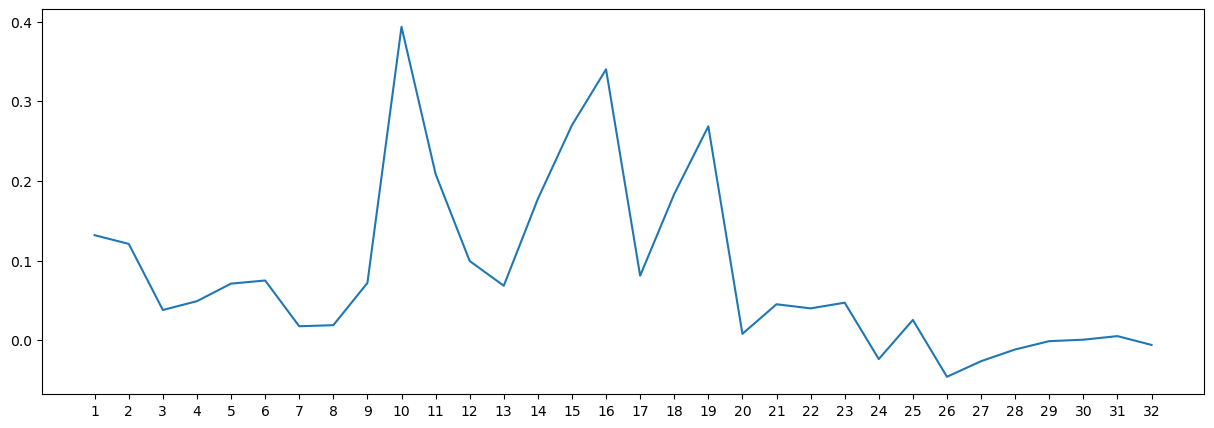

In [21]:
from scipy import stats
# features = ["h1n1_concern","h1n1_knowledge","behavioral_antiviral_meds","behavioral_avoidance"]
# features = df_feature.
pNUm = []
pX = []
i=0
for column in train_data.drop(columns=['h1n1_vaccine','seasonal_vaccine'],axis=1,inplace=False).columns.values:
    pearson_coef,p_value = stats.pearsonr(train_data[column],train_data['h1n1_vaccine'])
    pNUm.append(pearson_coef)
    pX.append(column)
    # print(column," : The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
print(pX)
plt.figure(figsize=[15,5])
plt.plot(range(1,33,1),pNUm)
plt.xticks(range(1,33,1))
plt.show()

In [22]:
train_data.corr()['h1n1_vaccine']

h1n1_concern                   0.131833
h1n1_knowledge                 0.120890
behavioral_antiviral_meds      0.037908
behavioral_avoidance           0.048984
behavioral_face_mask           0.071011
behavioral_wash_hands          0.074934
behavioral_large_gatherings    0.017475
behavioral_outside_home        0.018830
behavioral_touch_face          0.071834
doctor_recc_h1n1               0.393544
doctor_recc_seasonal           0.208674
chronic_med_condition          0.099398
child_under_6_months           0.068338
health_worker                  0.177413
opinion_h1n1_vacc_effective    0.269974
opinion_h1n1_risk              0.340110
opinion_h1n1_sick_from_vacc    0.080956
opinion_seas_vacc_effective    0.183534
opinion_seas_risk              0.268564
opinion_seas_sick_from_vacc    0.007941
age_group                      0.045094
education                      0.039936
race                           0.047079
sex                           -0.023736
income_poverty                 0.025397


pearson coefficient high  -> doctor_recc_h1n1   opinion_h1n1_risk     opinion_seas_risk

## Imputation

In [10]:
imp = IterativeImputer(random_state=0,initial_strategy="most_frequent")
imp.fit(train_data)

IterativeImputer(initial_strategy='most_frequent', random_state=0)

In [11]:
data = imp.transform(df_feature).round().astype(int)

## Feature Selection

In [ ]:
X = np.delete(data,[32,33],axis=1)
# y = df_label['h1n1_vaccine']
y = df_vac

### GradientBoost

In [ ]:
RFC_ = RFC(n_estimators=100,random_state=0).fit(X,y)
score = []
for i in range(5,34,1):
  x_wrapper = RFE(RFC_,n_features_to_select=i,step=1).fit_transform(X,y)
  once = cross_val_score(GradientBoostingClassifier(),x_wrapper,y,cv=10,scoring='roc_auc').mean()
  score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(5,34,1),score)
plt.xticks(range(5,34,1))
plt.show()

### CatBoost

In [ ]:
RFC_ = RFC(n_estimators=100,random_state=0).fit(X,y)
score = []
for i in range(5,32,1):
  x_wrapper = RFE(RFC_,n_features_to_select=i,step=3).fit_transform(X,y)
  once = cross_val_score(CatBoostClassifier(),x_wrapper,y,cv=10,scoring='roc_auc').mean()
  score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(5,32,1),score)
plt.xticks(range(5,32,1))
plt.show()

In [ ]:
selector = RFE(CatBoostClassifier(),verbose=2).fit(X,y)

In [ ]:
selector.ranking_

array([ 1,  1, 17, 15, 14, 16,  9, 12, 13,  1,  5, 10, 11,  4,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  7,  1,  8,  6,  1,  1,  2,  1,  3])

h1n1_vaccine: 
h1n1_concern 1	h1n1_knowledge 1 doctor_recc_h1n1 1 opinion_h1n1_vacc_effective 1	opinion_h1n1_risk 1	opinion_h1n1_sick_from_vacc 1	opinion_seas_vacc_effective 1	opinion_seas_risk 1	opinion_seas_sick_from_vacc 1 age_group 1	education 1	race 1 income_poverty 1 employment_status 1	hhs_geo_region 1 household_adults 1	census_msa 2 household_children	3 health_worker 4 doctor_recc_seasonal 5 rent_or_own 6 sex 7 marital_status 8 behavioral_large_gatherings 9 chronic_med_condition 10	child_under_6_months 11 behavioral_outside_home 12	behavioral_touch_face 13 behavioral_face_mask 14 behavioral_avoidance 15 behavioral_wash_hands  16	behavioral_antiviral_meds 17			 													


In [ ]:
pd.set_option('display.max_columns',None)

In [92]:
df_feature

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
0,2,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,...,4,1,3,2,1,2,9,3,0.0,0.0
1,4,3,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1,...,4,2,3,2,2,1,2,1,0.0,0.0
2,2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,4,2,1,2,1,1,10,1,2.0,0.0
3,2,2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,...,4,1,3,2,2,2,6,2,0.0,0.0
4,3,2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1,...,4,1,1,1,1,1,10,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,3,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,...,4,1,1,2,1,2,10,3,0.0,0.0
26703,2,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2,...,4,2,1,2,2,1,7,2,1.0,0.0
26704,3,3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1,...,4,1,0,2,1,0,7,1,0.0,0.0
26705,2,2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,2,1,1,1,2,1,6,3,1.0,0.0


In [ ]:
selector.get_feature_names_out(num_cols)

In [13]:
X = [[row[0]]+[row[1]]+[row[i] for i in range(9,12)]+[row[i] for i in range(13,20)] for row in data]
y = df_label['h1n1_vaccine']
y_sea = df_label['seasonal_vaccine']
y_total = df_label['h1n1_vaccine'] | df_label['seasonal_vaccine']

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## H1N1_vaccine

### UnderSampling

In [21]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_train,y_train = nm.fit_resample(X_train,y_train)

### Oversampling

In [43]:
from imblearn.over_sampling import SVMSMOTE
svmsmo = SVMSMOTE(random_state = 0)
X_train,y_train = svmsmo.fit_resample(X_train,y_train)

In [103]:
from imblearn.over_sampling import KMeansSMOTE
kmsmo = KMeansSMOTE(random_state = 0)
X_train,y_train = svmsmo.fit_resample(X_train,y_train)

In [36]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state = 0)
X_train,y_train = ada.fit_resample(X_train,y_train)

### Combine Under-Sampling and Over-Sampling

In [39]:
from imblearn.combine import SMOTETomek
smo = SMOTETomek(random_state=0)
X_train,y_train = smo.fit_resample(X_train,y_train)

In [95]:
from collections import Counter
Counter(y_train)

Counter({0: 14754, 1: 14754})

### CatBoosting

In [96]:
train_data_h1n1 = Pool(data = X_train,label = y_train,cat_features = [0,11])

In [99]:
def objective(trial):
    params_test1 = {
        "loss_function":"Logloss",
        "eval_metric":"AUC",
        "task_type":"GPU",
        'depth':trial.suggest_int("depth", 6,10),
        # 'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100),
        # 'border_count':trial.suggest_int("border_count", 10,50),
        'early_stopping_rounds':trial.suggest_int("early_stopping_rounds", 70,100),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.2),
        # 'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [30,40,50,100,150,200,256]),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_seed":42,
        "od_type":"Iter",
        }

    cat1 = CatBoostClassifier(**params_test1).fit(X_train,y_train,cat_features=[0,11],verbose=0)

    scores = cv(train_data_h1n1,params_test1,fold_count=5,verbose=0)

    return scores['test-AUC-mean'].max()

In [ ]:
study1 = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction="maximize")
study1.optimize(objective, n_trials = 100)

In [ ]:
optuna.visualization.plot_param_importances(study1)

In [ ]:
print("Number of completed trials: {}".format(len(study1.trials))) 
print("Best trial:") 
trial1 = study1.best_trial 
 
print("\tBest Score: {}".format(trial1.value)) 
print("\tBest Params: ") 
for key, value in trial1.params.items(): 
    print("    {}: {}".format(key, value))

In [ ]:
param_test1 = {'depth':range(4,10,1)}
CB1 = GridSearchCV(estimator = CatBoostClassifier(loss_function="Logloss",eval_metric="AUC",task_type="GPU",random_seed=42,od_type="Iter",), 
                       param_grid = param_test1, scoring='roc_auc',cv=10)
CB1.fit(X_train,y_train)
print(CB1.cv_results_,CB1.best_params_, CB1.best_score_)

In [68]:
test_param = {
    'depth': 6, 'l2_leaf_reg': 2.2430948663373496, 'early_stopping_rounds': 100, 'learning_rate': 0.01,"loss_function":"Logloss","eval_metric":"AUC",
    "task_type":"CPU","random_seed":42,"od_type":"Iter"
}

### Evaluation

In [69]:
model_h1n1 = CatBoostClassifier(verbose=False,  cat_features=[0,11],**test_param)
model_h1n1.fit(X_train,y_train)
y_pred_h1n1 = model_h1n1.predict(X_test)
y_predprob_h1n1 = model_h1n1.predict_proba(X_test)[:,1]
print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred_h1n1))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predprob_h1n1))

Accuracy : 0.7868
AUC Score (Train): 0.832560


Learning rate set to 0.5
0:	learn: 0.5294432	total: 2.91ms	remaining: 26.2ms
1:	learn: 0.4750291	total: 5.9ms	remaining: 23.6ms
2:	learn: 0.4496248	total: 8.41ms	remaining: 19.6ms
3:	learn: 0.4377583	total: 10.9ms	remaining: 16.3ms
4:	learn: 0.4314124	total: 13.4ms	remaining: 13.4ms
5:	learn: 0.4265098	total: 15.8ms	remaining: 10.6ms
6:	learn: 0.4238653	total: 18.3ms	remaining: 7.83ms
7:	learn: 0.4216008	total: 21.1ms	remaining: 5.27ms
8:	learn: 0.4199669	total: 23.7ms	remaining: 2.64ms
9:	learn: 0.4182228	total: 26.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5292469	total: 3.21ms	remaining: 28.9ms
1:	learn: 0.4753772	total: 6.41ms	remaining: 25.6ms
2:	learn: 0.4496226	total: 9.63ms	remaining: 22.5ms
3:	learn: 0.4379469	total: 13ms	remaining: 19.5ms
4:	learn: 0.4320945	total: 16ms	remaining: 16ms
5:	learn: 0.4265368	total: 19.1ms	remaining: 12.8ms
6:	learn: 0.4230579	total: 25.5ms	remaining: 10.9ms
7:	learn: 0.4213032	total: 32.5ms	remaining: 8.11ms
8:	learn: 0.4195997	tota

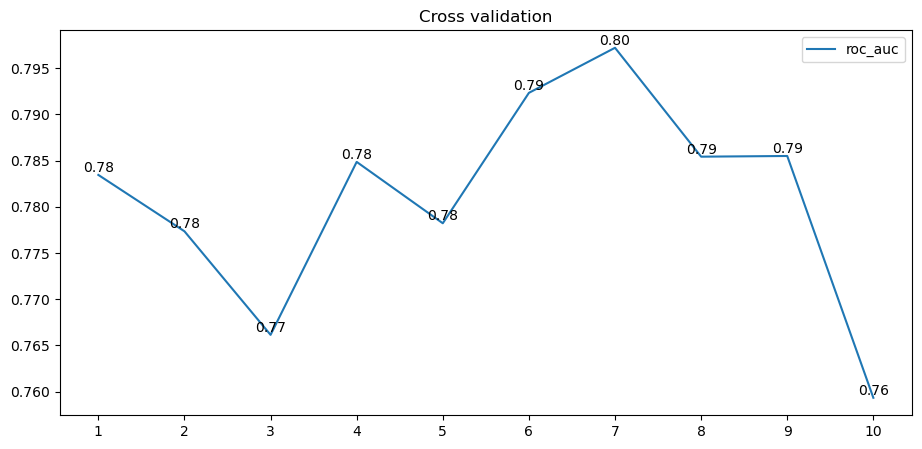

In [93]:
# scores = cross_val_score(model, X, y, cv=10,scoring='roc_auc')
# plt.figure(figsize=(11,5))
# labels = [1, 2, 3, 4, 5,6,7,8,9,10]
# plt.plot(labels, scores, label=u'roc_auc')
# plt.xticks(labels)
# for x, y in zip((labels), scores):
#     plt.text(x, y,"%.2f" % y, ha="center", va="bottom",fontsize=10)
# plt.title("Cross validation")
# plt.legend()
# plt.show()

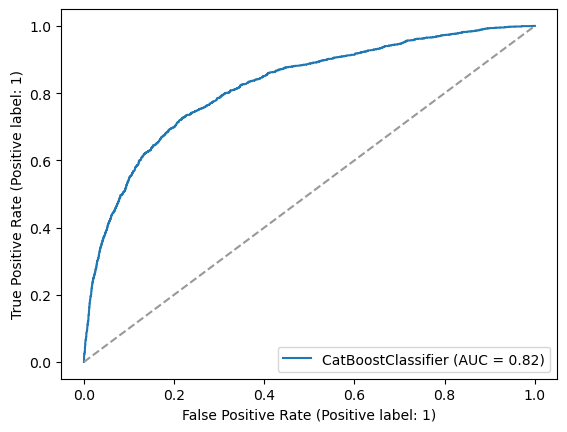

In [36]:
svc_disp = RocCurveDisplay.from_estimator(model_h1n1, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      6279
           1       0.51      0.72      0.59      1734

    accuracy                           0.79      8013
   macro avg       0.71      0.76      0.72      8013
weighted avg       0.82      0.79      0.80      8013



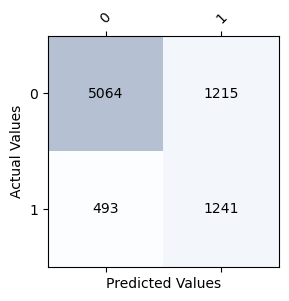

In [70]:
cm = confusion_matrix(y_test, y_pred_h1n1)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
            s=cm[i, j], 
            va='center', ha='center')
        
classes=["0","1"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');
print(classification_report(y_test, y_pred_h1n1))

## Seaconal_vaccine

### CatBoosting

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_sea_train, y_sea_test = train_test_split(X, y_sea, test_size = 0.2, random_state = 0)

In [73]:
train_data_seasonal = Pool(data = X_train,label = y_sea_train,cat_features = [0,11])

In [90]:
def objective2(trial):
    params_test2 = {
        "loss_function":"Logloss",
        "eval_metric":"AUC",
        "task_type":"GPU",
        'depth':trial.suggest_int("depth", 2,10),
        # 'iterations':trial.suggest_categorical('iterations', [500,1000,3000,5000,10000,15000,20000]),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100),
        'border_count':trial.suggest_int("border_count", 10,50),
        'early_stopping_rounds':trial.suggest_int("early_stopping_rounds", 10,100),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [10,31,50,100,150,200,256]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_seed":42,
        "od_type":"Iter"
        }
    
    if params_test2["bootstrap_type"] == "Bayesian":
        params_test2["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params_test2["bootstrap_type"] == "Bernoulli":
        params_test2["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat2 = CatBoostClassifier(**params_test2).fit(X_train,y_sea_train,cat_features=[0,11],verbose=0)

    scores = f1_score(y_sea_test,cat2.predict(X_test))
    # avg = scores.mean()
    return scores

In [ ]:
study2 = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction="maximize")
study2.optimize(objective2, n_trials = 100)

In [ ]:
optuna.visualization.plot_param_importances(study2)

In [ ]:
print("Number of completed trials: {}".format(len(study2.trials))) 
print("Best trial:") 
trial2 = study2.best_trial 
 
print("\tBest Score: {}".format(trial2.value)) 
print("\tBest Params: ") 
for key, value in trial2.params.items(): 
    print("    {}: {}".format(key, value))

### Evaluation

In [ ]:
model_seasonal = CatBoostClassifier(verbose=False,  cat_features=[0,11], **trial2.params)
model_seasonal.fit(X_train,y_sea_train)
y_pred_seasonal = model_seasonal.predict(X_test)
y_predprob_seasonal = model_seasonal.predict_proba(X_test)[:,1]
print ("Accuracy : %.4g" % metrics.accuracy_score(y_sea_test, y_pred_seasonal))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_sea_test, y_predprob_seasonal))

In [ ]:
svc_disp = RocCurveDisplay.from_estimator(model_seasonal, X_test, y_sea_test)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.show()

In [ ]:
cm = confusion_matrix(y_sea_test, y_pred_seasonal)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
            s=cm[i, j], 
            va='center', ha='center')
        
classes=["0","1"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');
print(classification_report(y_sea_test, y_pred_seasonal))

## Total

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_total_train, y_total_test = train_test_split(X, y_total, test_size = 0.2, random_state = 0)

In [ ]:
train_data_seasonal = Pool(data = X_train,label = y_total_train,
                       cat_features = [0,11])

In [ ]:
def objective3(trial):
    params_test3 = {
        "loss_function":"Logloss",
        "eval_metric":"AUC",
        "task_type":"GPU",
        'depth':trial.suggest_int("depth", 2,10),
        # 'iterations':trial.suggest_categorical('iterations', [500,1000,3000,5000,10000,15000,20000]),
        'l2_leaf_reg':trial.suggest_float("l2_leaf_reg", 1e-8, 100),
        'border_count':trial.suggest_int("border_count", 10,50),
        'early_stopping_rounds':trial.suggest_int("early_stopping_rounds", 10,100),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [10,31,50,100,150,200,256]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_seed":42,
        "od_type":"Iter"
        }
    
    if params_test3["bootstrap_type"] == "Bayesian":
        params_test3["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params_test3["bootstrap_type"] == "Bernoulli":
        params_test3["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat3 = CatBoostClassifier(**params_test3).fit(X_train,y_total_train,cat_features=[0,11],verbose=0)

    scores = f1_score(y_total_test,cat3.predict(X_test))
    # avg = scores.mean()
    return scores

In [ ]:
study3 = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction="maximize")
study3.optimize(objective3, n_trials = 100)

In [ ]:
optuna.visualization.plot_param_importances(study3)

In [ ]:
print("Number of completed trials: {}".format(len(study3.trials))) 
print("Best trial:") 
trial3 = study3.best_trial 
 
print("\tBest Score: {}".format(trial3.value)) 
print("\tBest Params: ") 
for key, value in trial3.params.items(): 
    print("    {}: {}".format(key, value))